# LightGBMの学習→予測→評価

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install seaborn==0.12.2
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5
# !pip install shap==0.41.0

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__) 
print(lgb.__version__)

1.5.3
1.22.4
3.7.1
0.12.2
1.2.2
3.3.5


In [3]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
#df.head()

In [4]:
# 前処理

# 文字列の半角スペース削除
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)

#print(df.shape)
#df.head()

In [5]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']

In [6]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (23336, 13)  y_trainの形状： (23336,)  X_testの形状： (5834, 13)  y_testの形状： (5834,)


In [7]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

#X_train.info()

In [8]:
# カテゴリ変数のデータ型をcategory型に変換
for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23336 entries, 14415 to 5640
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             23336 non-null  int64   
 1   workclass       23336 non-null  category
 2   fnlwgt          23336 non-null  int64   
 3   education       23336 non-null  category
 4   education-num   23336 non-null  int64   
 5   marital-status  23336 non-null  category
 6   occupation      23336 non-null  category
 7   relationship    23336 non-null  category
 8   race            23336 non-null  category
 9   gender          23336 non-null  category
 10  capital-gain    23336 non-null  int64   
 11  capital-loss    23336 non-null  int64   
 12  hours-per-week  23336 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 1.4 MB


In [9]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'binary',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

In [10]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train],
                  valid_names=['train'],
                  callbacks=[lgb.log_evaluation(100)])

[100]	train's binary_logloss: 0.287802
[200]	train's binary_logloss: 0.275191
[300]	train's binary_logloss: 0.266737
[400]	train's binary_logloss: 0.260694
[500]	train's binary_logloss: 0.255673


In [11]:
# テストデータの予測と評価
y_test_pred_proba = model.predict(X_test) # ラベル1の確率
print('ラベル1の確率：', y_test_pred_proba)
y_test_pred = np.round(y_test_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_test_pred)

ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

ラベル1の確率： [0.00861277 0.19313881 0.30667979 ... 0.99818521 0.04753307 0.03750745]
予測ラベル値： [0. 0. 0. ... 1. 0. 0.]
accuracy = 0.86
F1-score = 0.69


Text(45.722222222222214, 0.5, 'label')

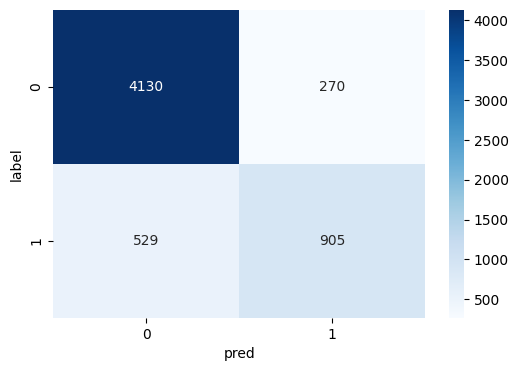

In [12]:
# 混同行列
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('label')

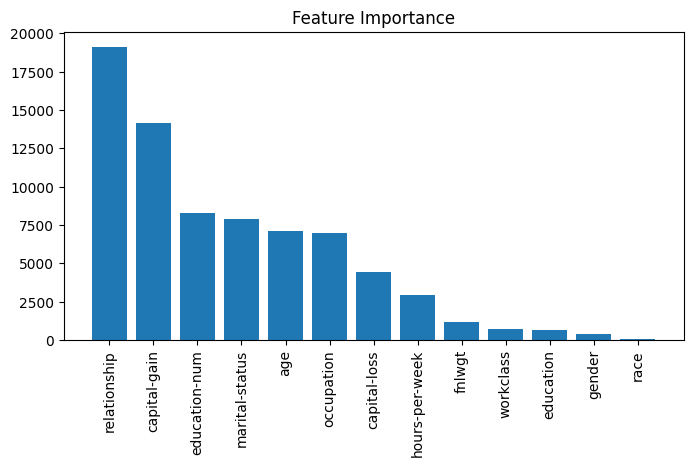

In [13]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title("Feature Importance") # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

<Axes: >

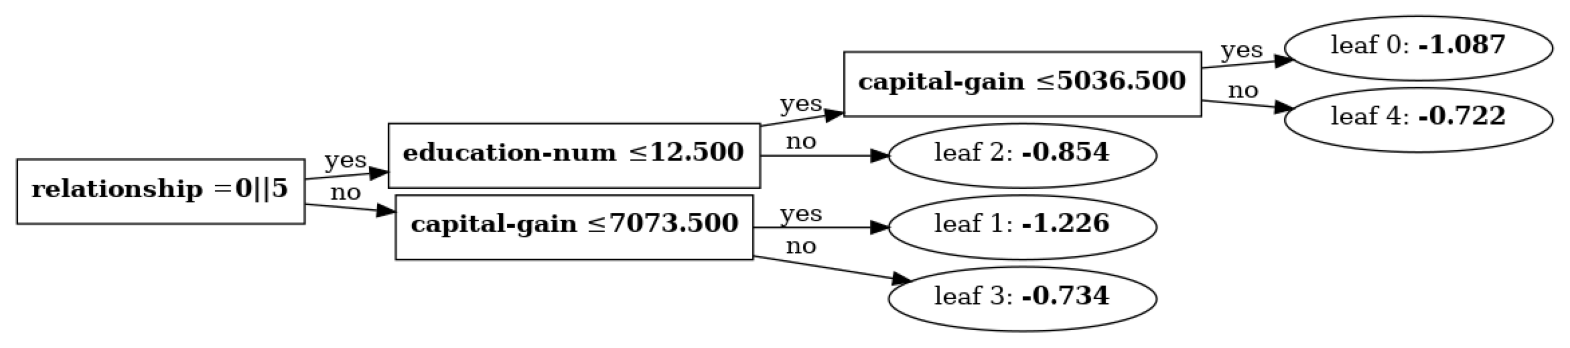

In [14]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))

# SHAP

In [15]:
# 最後から3件目の予測値
y_test_pred_proba[-3]

0.9981852074044177

In [16]:
# ライブラリshapのインストール
! pip install shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [17]:
import shap
shap.__version__

/home/takuya/.cache/pypoetry/virtualenvs/lightgbm-sample-qPUWcycm-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.41.0'

In [18]:
# explainerの作成
import shap

explainer = shap.TreeExplainer(
    model = model,
    feature_perturbation = 'tree_path_dependent')

In [19]:
# SHAP値の計算
shap_values = explainer(X_test)

In [20]:
# 全件レコードの期待値
explainer.expected_value

[2.4255437226226246, -2.4255437226226246]

In [21]:
# 最後から3件目のSHAP値
shap_values[-3]

.values =
array([[-0.58106716,  0.58106716],
       [-0.0544556 ,  0.0544556 ],
       [-0.1093893 ,  0.1093893 ],
       [ 0.07626617, -0.07626617],
       [ 0.26401627, -0.26401627],
       [-0.65721149,  0.65721149],
       [-0.52462177,  0.52462177],
       [-0.41675398,  0.41675398],
       [-0.01607797,  0.01607797],
       [-0.16606463,  0.16606463],
       [-6.35894357,  6.35894357],
       [ 0.02788182, -0.02788182],
       [-0.21909016,  0.21909016]])

.base_values =
array([ 2.42554372, -2.42554372])

.data =
array([    58,      4, 147707,     11,      9,      2,      4,      0,
            4,      1,  15024,      0,     60])

In [22]:
# shap_valuesのラベル1のへの絞り込み
shap_values.values = shap_values.values[:, :, 1] # 貢献度
shap_values.base_values = explainer.expected_value[1] #期待値

In [23]:
# 最後から3件目のSHAP値（ラベル1）
shap_values[-3]

.values =
array([ 0.58106716,  0.0544556 ,  0.1093893 , -0.07626617, -0.26401627,
        0.65721149,  0.52462177,  0.41675398,  0.01607797,  0.16606463,
        6.35894357, -0.02788182,  0.21909016])

.base_values =
-2.4255437226226246

.data =
array([    58,      4, 147707,     11,      9,      2,      4,      0,
            4,      1,  15024,      0,     60])

In [24]:
# 最後から3件目の貢献度
shap_values.values[-3]

array([ 0.58106716,  0.0544556 ,  0.1093893 , -0.07626617, -0.26401627,
        0.65721149,  0.52462177,  0.41675398,  0.01607797,  0.16606463,
        6.35894357, -0.02788182,  0.21909016])

In [25]:
# 最後から3件目の貢献度合計
shap_values.values[-3].sum()

8.735511371497317

In [26]:
# 期待値＋最後から3件目の貢献度合計
shap_values[-3].base_values + shap_values.values[-3].sum()

6.309967648874693

In [27]:
# 最後から3件目のラベル1の確率

# SHAP値合計をlogitに設定
logit = shap_values[-3].base_values + shap_values.values[-3].sum()

# シグモイド関数でlogitから確率に変換
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(logit)

0.9981852074044177

In [28]:
# 最後から3件目の予測値
y_test_pred_proba[-3]

0.9981852074044177

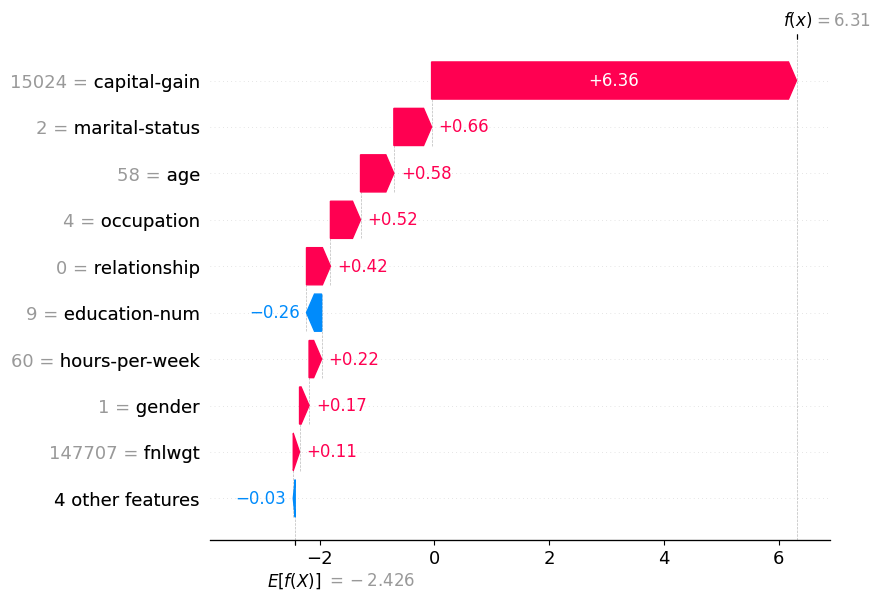

In [29]:
# 最後から3件目のSHAP値の可視化
shap.plots.waterfall(shap_values[-3])

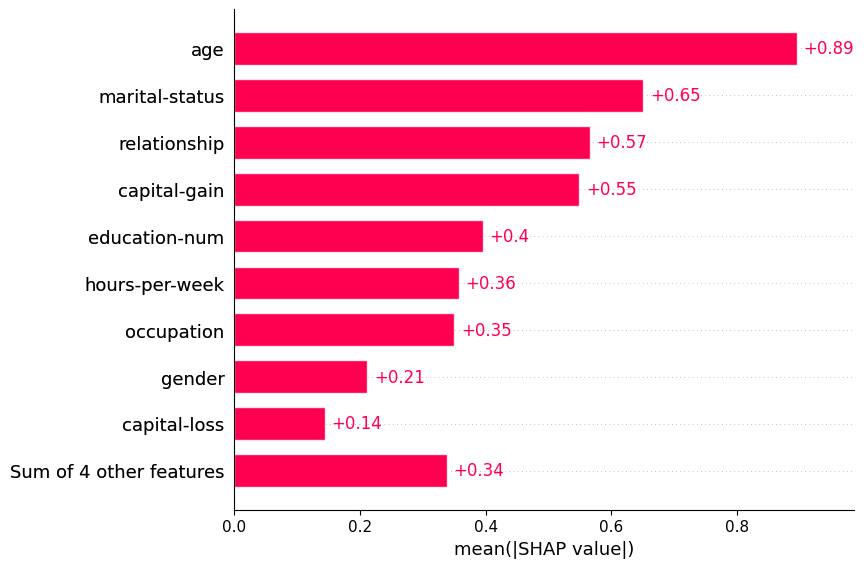

In [30]:
# 重要度の可視化
shap.plots.bar(shap_values=shap_values)